In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def correct_dimensions(s, targetlength):
    """ проверяет размерность некоторого числового аргумента s, транслирует его
       на заданную длину, если это возможно.

    Аргументы:
        s: None, скаляр или одномерный массив
        targetlength: ожидаемая длина s
        
    Возвращает:
        None, если s - None, иначе numpy-вектор длины targetlength.
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s

def identity(x):
    return x

In [4]:
correct_dimensions([1,2,3], 3)

array([1, 2, 3])

In [5]:
class ESN:
    def __init__(
        self, 
        n_inputs, 
        n_outputs, 
        n_reservoir=200,
        spectral_radius=0.95, 
        sparsity=0, 
        noise=0.001, 
        input_shift=None,
        input_scaling=None, 
        teacher_forcing=True, 
        feedback_scaling=None,
        teacher_scaling=None, 
        teacher_shift=None,
        out_activation=identity, 
        inverse_out_activation=identity,
        random_state=None,
        silent=True):
        """
        Аргументы:
            n_inputs: nr входных измерений
            n_outputs: nr выходных измерений
            n_резервуар: nr нейронов резервуара
            spectral_radius: спектральный радиус рекуррентной весовой матрицы
            разреженность: доля рекуррентных весов, установленных на ноль
            noise: шум, добавляемый к каждому нейрону (регуляризация)
            input_shift: скаляр или вектор длины n_inputs для добавления к каждому
                        входному измерению перед подачей в сеть.
            input_scaling: скаляр или вектор длины n_входов для умножения
                        с каждым входным измерением перед подачей в сеть.
            teacher_forcing: если True, вернуть цель в выходные единицы.
            teacher_scaling: коэффициент, применяемый к целевому сигналу
            teacher_shift: аддитивный член, применяемый к целевому сигналу
            out_activation: выходная функция активации (применяется к считыванию)
            inverse_out_activation: обратная функция активации на выходе
            random_state: положительная целочисленная затравка, объект np.rand.RandomState,
                          или None для использования встроенного в numpy RandomState.
            silent: подавлять сообщения
        """

        self.n_inputs                   = n_inputs
        self.n_reservoir                = n_reservoir
        self.n_outputs                  = n_outputs
        self.spectral_radius            = spectral_radius
        self.sparsity                   = sparsity
        self.noise                      = noise
        self.input_shift                = correct_dimensions(input_shift, n_inputs)
        self.input_scaling              = correct_dimensions(input_scaling, n_inputs)

        self.teacher_scaling            = teacher_scaling
        self.teacher_shift              = teacher_shift

        self.out_activation             = out_activation
        self.inverse_out_activation     = inverse_out_activation
        self.random_state               = random_state

        self.teacher_forcing = teacher_forcing
        self.silent = silent

        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        
        self.initweights()

    def initweights(self):
        # инициализация рекуррентных весов:
        # начинаем со случайной матрицы, центрированной вокруг нуля:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5
        # удалите долю связей, заданную (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0
        # вычислить спектральный радиус этих весов:
        radius = np.max(np.abs(np.linalg.eigvals(W)))
        # изменить их масштаб для достижения требуемого спектрального радиуса:
        self.W = W * (self.spectral_radius / radius)
        # случайные входные веса:
        self.W_in = self.random_state_.rand(self.n_reservoir, self.n_inputs) * 2 - 1
        # случайные веса обратной связи (принуждение учителя):
        self.W_feedb = self.random_state_.rand(self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern):
        """выполняет один шаг обновления.
        т.е. вычисляет следующее состояние сети, применяя рекуррентные веса
        к последнему состоянию & и вводит текущие входные и выходные шаблоны.
        """
        if self.teacher_forcing:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern) + np.dot(self.W_feedb, output_pattern))
        else:
            preactivation = (np.dot(self.W, state) + np.dot(self.W_in, input_pattern))
        return (np.tanh(preactivation) + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """для каждой входной размерности j: умножается на j-ю запись в аргументе
        аргумент input_scaling, затем добавляет j-ю запись аргумента input_shift
        аргумента."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """умножает сигнал учитель/цель на аргумент учитель_масштабирование,
        затем добавляет к нему аргумент teacher_shift."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """обратная операция метода _scale_teacher"""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Собирает реакцию сети на обучающие данные, обучает считыванию весов.
        Аргументы:
            inputs: массив размерности (N_training_samples x n_inputs)
            outputs: массив размерности (N_training_samples x n_outputs)
            inspect: показать визуализацию собранных состояний резервуара.
        Возвращает:
            выход сети на обучающих данных с использованием обученных весов.
        """
        # преобразовать любые векторы формы (x,) в векторы формы (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # преобразование входного сигнала и сигнала преподавателя:
        inputs_scaled = self._scale_inputs(inputs)
        teachers_scaled = self._scale_teacher(outputs)
        
        if not self.silent:
            print("harvesting states...")
        # проведите резервуар через заданные пары вход-выход:
        states = np.zeros((inputs.shape[0], self.n_reservoir))
        for n in range(1, inputs.shape[0]):
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :],
                                        teachers_scaled[n - 1, :])

        # выучить веса, т.е. найти линейную комбинацию собранных
        # состояний сети, которая наиболее близка к целевому выходу
        if not self.silent:
            print("fitting...")
        # мы проигнорируем первые несколько состояний:
        transient = min(int(inputs.shape[1] / 10), 100)
        # включить необработанные входные данные
        extended_states = np.hstack((states, inputs_scaled))
        # Решите для W_out:
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]), self.inverse_out_activation(teachers_scaled[transient:, :])).T

        # запомнить последнее состояние на потом:# запомнить последнее состояние на потом:
        self.laststate = states[-1, :]
        self.lastinput = inputs[-1, :]
        self.lastoutput = teachers_scaled[-1, :]

        # опционально визуализировать собранные состояния
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- мы зависим от matplotlib, только если используется эта опция)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # применить выученные веса к собранным состояниям:
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T)))
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def synchronize(self, inputs, outputs):
            """
            Синхронизировать состояние резервуара с заданными входами и выходами.
            Аргументы:
                входы: массив размерности (N_обучающих_образцов x n_входов)
                выходы: массив размерности (N_обучающих_образцов x n_выходов)
            Возвращает:
                Массив выходных активаций
            """

            if inputs.ndim < 2:
                inputs = np.reshape(inputs, (len(inputs), -1))
            if outputs.ndim < 2:
                outputs = np.reshape(outputs, (len(outputs), -1))
            n_samples = inputs.shape[0]

            inputs_scaled = self._scale_inputs(inputs)
            teachers_scaled = self._scale_teacher(outputs)
            states = np.zeros((n_samples, self.n_reservoir))
    #        outputs = np.vstack(
    #            [lastoutput, np.zeros((n_samples, self.n_outputs))])

    #        inputs = np.vstack([self.lastinput, self._scale_inputs(inputs)])

            for n in range(1, n_samples):
                states[n, :] = self._update(states[n - 1, :], inputs[n, :], outputs[n - 1, :])
                esn_output = self.out_activation(np.dot(self.W_out, np.concatenate([states[n, :], inputs[n, :]])))

            self.laststate = states[-1, :]
            self.lastinput = inputs_scaled[-1, :]
            self.lastoutput = teachers_scaled[-1, :]

            return self._unscale_teacher(self.out_activation(outputs[1:]))

    def predict(self, inputs, continuation=True):
        """
        Применить выученные веса к реакции сети на новые входные данные.
        Аргументы:
            inputs: массив размерности (N_test_samples x n_inputs)
            продолжение: если True, запустить сеть из последнего состояния обучения.
        Возвращает:
            Массив выходных активаций
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation:
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else:
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)])
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))])
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))])

        for n in range(n_samples):
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :])
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out,
                                                            np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))



In [6]:
rng = np.random.RandomState(42)

In [118]:
def frequency_generator(N,min_period,max_period,n_changepoints):
    """returns a random step function with N changepoints
       and a sine wave signal that changes its frequency at
       each such step, in the limits given by min_ and max_period."""
    # vector of random indices < N, padded with 0 and N at the ends:
    changepoints = np.insert(np.sort(rng.randint(0,N,n_changepoints)),[0,n_changepoints],[0,N])
    # list of interval boundaries between which the control sequence should be constant:
    const_intervals = list(zip(changepoints,np.roll(changepoints,-1)))[:-1]
    # populate a control sequence
    frequency_control = np.zeros((N,1))
    for (t0,t1) in const_intervals:
        frequency_control[t0:t1] = rng.rand()
    periods = frequency_control * (max_period - min_period) + max_period
    # run time through a sine, while changing the period length
    frequency_output = np.zeros((N,1))
    z = 0
    for i in range(N):
        z = z + 2 * np.pi / periods[i]
        frequency_output[i] = (np.sin(z) + 1)/2
    return np.hstack([np.ones((N,1)),1-frequency_control]),frequency_output


N = 15000 # signal length
min_period = 2
max_period = 10
n_changepoints = int(N/200)
frequency_control,frequency_output = frequency_generator(N,min_period,max_period,n_changepoints)

traintest_cutoff = int(np.ceil(0.7*N))

train_ctrl,train_output = frequency_control[:traintest_cutoff],frequency_output[:traintest_cutoff]
test_ctrl, test_output  = frequency_control[traintest_cutoff:],frequency_output[traintest_cutoff:]

In [7]:
esn = ESN(n_inputs = 2,
          n_outputs = 1,
          n_reservoir = 200,
          spectral_radius = 0.25,
          sparsity = 0.95,
          noise = 0.001,
          input_shift = [0,0],
          input_scaling = [0.01, 3],
          teacher_scaling = 1.12,
          teacher_shift = -0.7,
          out_activation = np.tanh,
          inverse_out_activation = np.arctanh,
          random_state = rng,
          silent = False)

In [8]:
pred_train = esn.fit(train_ctrl,train_output)

print("test error:")
pred_test = esn.predict(test_ctrl)
print(np.sqrt(np.mean((pred_test - test_output)**2)))

NameError: name 'train_ctrl' is not defined

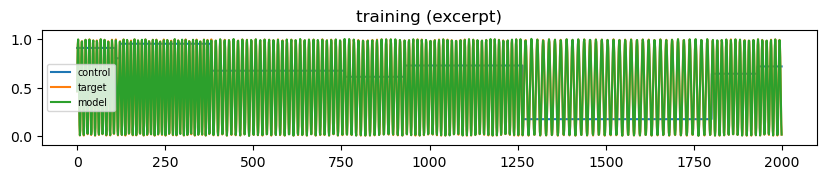

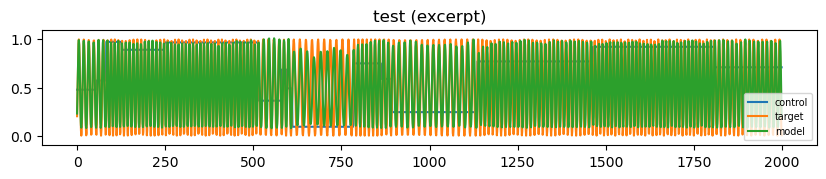

In [ ]:
window_tr = range(int(len(train_output)/4),int(len(train_output)/4+2000))
plt.figure(figsize=(10,1.5))
plt.plot(train_ctrl[window_tr,1],label='control')
plt.plot(train_output[window_tr],label='target')
plt.plot(pred_train[window_tr],label='model')
plt.legend(fontsize='x-small')
plt.title('training (excerpt)')
plt.ylim([-0.1,1.1])

window_test = range(2000)
plt.figure(figsize=(10,1.5))
plt.plot(test_ctrl[window_test,1],label='control')
plt.plot(test_output[window_test],label='target')
plt.plot(pred_test[window_test],label='model')
plt.legend(fontsize='x-small')
plt.title('test (excerpt)')
plt.ylim([-0.1,1.1]);

In [9]:
x = np.linspace(0, 2*np.pi*10)
y = np.sin(x)